# Capstone project: Function 7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern, WhiteKernel
import matplotlib.pyplot as plt
import sklearn
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization


/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'bayes_opt'

## Function 7 description

You’re tasked with optimising an ML model by tuning six hyperparameters, for example learning rate, regularisation strength or number of hidden layers. The function you’re maximising is the model’s performance score (such as accuracy or F1), but since the relationship between inputs and output isn’t known, it’s treated as a black-box function. 

Because this is a commonly used model, you might benefit from researching best practices or literature to guide your initial search space. Your goal is to find the combination of hyperparameters that yields the highest possible performance.

Input array 6D (30,6), output array 1D (30,1)

### Step 1: Load in the data

In [3]:
X = np.load('initial_inputs.npy')
y = np.load('initial_outputs.npy')

inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

print(X,y)

[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72880565

### Step 2: Use a surrogate model - Gaussian processor

In [4]:
kernel = Matern(length_scale=np.ones(6)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-5)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X, y)

GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=1e-05),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

### Step 3: Wrap GP into function for optimiser

In [5]:
def gp_predict(hp1, hp2, hp3, hp4, hp5, hp6):
    X_new = np.array([[hp1, hp2, hp3, hp4, hp5, hp6]])
    mu = gp.predict(X_new, return_std=False)[0]
    return mu

#Define the bounds for each hyperparameter
pbounds = {
    'hp1': (0,1), 'hp2': (0,1), 'hp3': (0,1),
    'hp4': (0,1), 'hp5': (0,1), 'hp6': (0,1)
}

### Step 4: Fit acquisition function - in this case we are going for EI

In [6]:
optimizer = BayesianOptimization(
    f=gp_predict,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

#Suggest next hyperparameter combinations
optimizer.maximize(
    init_points=0,  # we already have existing data
    n_iter=5        # number of new candidate hyperparameters to suggest
)

|   iter    |  target   |    hp1    |    hp2    |    hp3    |    hp4    |    hp5    |    hp6    |
-------------------------------------------------------------------------------------------------
| 1         | 0.2122033 | 0.3745401 | 0.9507143 | 0.7319939 | 0.5986584 | 0.1560186 | 0.1559945 |
| 2         | 0.1651222 | 1.0       | 0.0       | 0.0       | -.383e-20 | 1.0       | 1.0       |
| 3         | 0.5586431 | 0.7188318 | 0.4888343 | 0.7761245 | 0.1761670 | 0.5452976 | 0.7064377 |
| 4         | 0.0478263 | 0.6725387 | 0.6624518 | 0.6475568 | 0.9380567 | 0.5281005 | 0.5977864 |
| 5         | 0.3560852 | 0.7363565 | 0.0485353 | 0.9541128 | 0.3021407 | 0.1291193 | 0.9754970 |
| 6         | 0.1431928 | 0.2993962 | 0.5142244 | 0.1035203 | 0.4393784 | 0.1405865 | 0.0328803 |


### Step 5: Identify next logical hyperparameter

In [8]:
print("Next best hyperparameters to try")
print(optimizer.max['params'])
print("Predicted performance score:", optimizer.max['target'])

Next best hyperparameters to try
{'hp1': np.float64(0.7188318975605293), 'hp2': np.float64(0.48883435644827467), 'hp3': np.float64(0.7761245780523243), 'hp4': np.float64(0.17616702753944347), 'hp5': np.float64(0.545297656690408), 'hp6': np.float64(0.7064377235385878)}
Predicted performance score: 0.5586431033852992


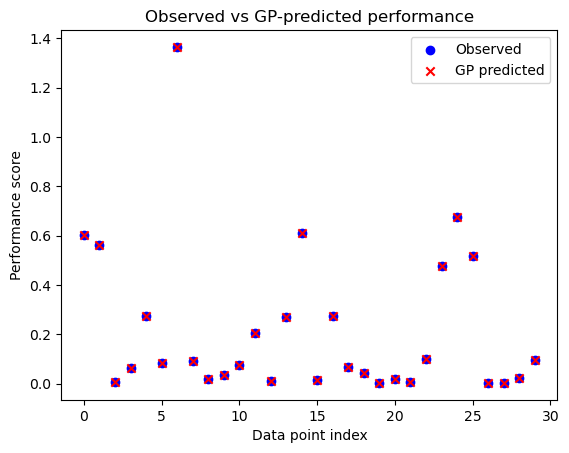

In [10]:
y_pred = gp.predict(X)

plt.scatter(range(len(y)), y, label='Observed', color='blue')
plt.scatter(range(len(y_pred)), y_pred, label='GP predicted', color='red', marker='x')
plt.xlabel('Data point index')
plt.ylabel('Performance score')
plt.title('Observed vs GP-predicted performance')
plt.legend()
plt.show()

# ******* Week 2 data updates and optimisation *********

## Step 1: Load in the new data

In [4]:
inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week1/inputs.txt', 'r') as f:
    inputs_week2 = f.read()

with open('../Inputs_Outputs/Week1/outputs.txt', 'r') as f:
    outputs_week2 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week2 = eval(inputs_week2, {"__builtins__": {}}, safe_globals)
outputs_week2 = eval(outputs_week2, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week2 = np.array(inputs_week2, dtype=object)
outputs_week2 = np.array(outputs_week2, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F7_inputs_week2 = inputs_week2[6]
F7_outputs_week2 = outputs_week2[6]



# Step 5: merge with previous data
F7_inputs_week2 = F7_inputs_week2.reshape(1, -1)
inputdata_week2 = np.concatenate((inputdata,F7_inputs_week2), axis=0)

outputdata_week2 = np.concatenate((outputdata,np.array([F7_outputs_week2])))

print(inputdata_week2)
print(outputdata_week2)

#Save results
np.save('inputs_week2.npy', inputdata_week2)
np.save('outputs_week2.npy', outputdata_week2)

[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72880565

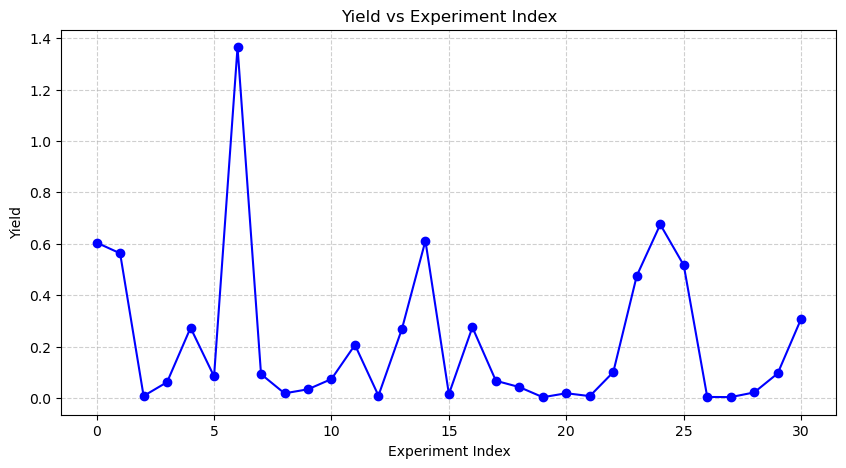

Best parameters: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Best yield: 1.3649683044991994


In [7]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week2))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week2, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week2)
best_x = inputdata_week2[best_idx]
best_y = outputdata_week2[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## step 2: Fit the new surrogate model

In [9]:
X_wk2 = inputdata_week2
y_wk2 = outputdata_week2

kernel = Matern(length_scale=np.ones(6)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-8)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X_wk2, y_wk2)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=1e-08),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

In [10]:
# Wrap GP into function for optimisation
def gp_predict(hp1, hp2, hp3, hp4, hp5, hp6):
    X_new = np.array([[hp1, hp2, hp3, hp4, hp5, hp6]])
    mu = gp.predict(X_new, return_std=False)[0]
    return mu

#Define the bounds for each hyperparameter
pbounds = {
    'hp1': (0,1), 'hp2': (0,1), 'hp3': (0,1),
    'hp4': (0,1), 'hp5': (0,1), 'hp6': (0,1)
}

## Step 3: Select acquisition approach

In [13]:
optimizer = BayesianOptimization(
    f=gp_predict,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

#Suggest next hyperparameter combinations
optimizer.maximize(
    init_points=0,  # we already have existing data
    n_iter=40        # number of new candidate hyperparameters to suggest
)

|   iter    |  target   |    hp1    |    hp2    |    hp3    |    hp4    |    hp5    |    hp6    |
-------------------------------------------------------------------------------------------------
| 1         | 0.2115240 | 0.3745401 | 0.9507143 | 0.7319939 | 0.5986584 | 0.1560186 | 0.1559945 |
| 2         | 0.1668490 | 1.0       | 0.0       | 0.0       | -.383e-20 | 1.0       | 1.0       |
| 3         | 0.3083537 | 0.7188318 | 0.4888343 | 0.7761245 | 0.1761670 | 0.5452976 | 0.7064377 |
| 4         | 0.0718360 | 0.6725387 | 0.6624518 | 0.6475568 | 0.9380567 | 0.5281005 | 0.5977864 |
| 5         | 0.3900217 | 0.7363565 | 0.0485353 | 0.9541128 | 0.3021407 | 0.1291193 | 0.9754970 |
| 6         | -0.003318 | 0.7863163 | 0.5279342 | 0.7938420 | 0.1446460 | 0.6780395 | 0.6935394 |
| 7         | 0.0884943 | 0.9895463 | 0.8917048 | 0.9571468 | 0.6213614 | 0.3044547 | 0.0132007 |
| 8         | 0.1251575 | 0.9603850 | 0.9979132 | 0.5723483 | 0.2028769 | 0.6190895 | 0.8285518 |
| 9         | 0.2979

In [15]:
#Identify next parameters
rounded_params = {k: round(v, 6) for k, v in optimizer.max['params'].items()}
rounded_target = round(optimizer.max['target'], 6)

print("\n=== Next best hyperparameters to try ===")
print(rounded_params)
print("Predicted performance score:", rounded_target)


=== Next best hyperparameters to try ===
{'hp1': np.float64(0.203504), 'hp2': np.float64(0.857965), 'hp3': np.float64(0.790582), 'hp4': np.float64(0.147198), 'hp5': np.float64(0.397214), 'hp6': np.float64(0.72118)}
Predicted performance score: 1.238285


# ******** Week 3: Update data for optimisation *******

### Step 1: Load in new data

In [5]:
inputdata = np.load('inputs_week2.npy')
outputdata = np.load('outputs_week2.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week2/inputs.txt', 'r') as f:
    inputs_week3 = f.read()

with open('../Inputs_Outputs/Week2/outputs.txt', 'r') as f:
    outputs_week3 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week3 = eval(inputs_week3, {"__builtins__": {}}, safe_globals)
outputs_week3 = eval(outputs_week3, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week3 = np.array(inputs_week3, dtype=object)
outputs_week3 = np.array(outputs_week3, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F7_inputs_week3 = inputs_week3[6]
F7_outputs_week3 = outputs_week3[6]



# Step 5: merge with previous data
F7_inputs_week3 = F7_inputs_week3.reshape(1, -1)
inputdata_week3 = np.concatenate((inputdata,F7_inputs_week3), axis=0)

outputdata_week3 = np.concatenate((outputdata,np.array([F7_outputs_week3])))

print(inputdata_week3)
print(outputdata_week3)

#Save results
np.save('inputs_week3.npy', inputdata_week3)
np.save('outputs_week3.npy', outputdata_week3)

[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72880565

### Step 2: Plot the results of this weeks updates

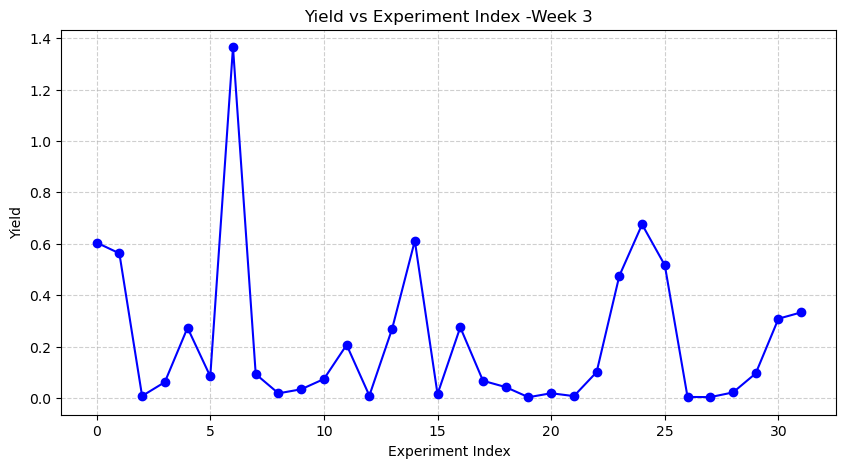

Best parameters: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Best yield: 1.3649683044991994


In [6]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week3))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week3, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 3')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week3)
best_x = inputdata_week2[best_idx]
best_y = outputdata_week2[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

### Step 3: Update the surrogate model for optimisation

In [7]:
X_wk3 = inputdata_week3
y_wk3 = outputdata_week3

kernel = Matern(length_scale=np.ones(6)*0.3, nu=2.5) + WhiteKernel(noise_level=1e-8)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, normalize_y=True, random_state=0)
gp.fit(X_wk3, y_wk3)

/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3], nu=2.5) + WhiteKernel(noise_level=1e-08),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=0)

### Step 4: Update acquisition function - focusing more on exploitation

In [11]:
n_candidates = 5000
low = np.zeros(6)  # scaled lower bounds
high = np.ones(6)  # scaled upper bounds
rng = np.random.default_rng(0)
X_candidates = rng.uniform(low=low, high=high, size=(n_candidates, 6))

mu, sigma = gp.predict(X_candidates, return_std=True)
kappa = 2.0  # controls exploration vs exploitation
UCB = mu + kappa * sigma

# Select next best candidate
next_idx = np.argmax(UCB)
x_next_scaled = X_candidates[next_idx]
print("Next suggested hyperparameters (scaled):", np.round(x_next_scaled,6))
print("Predicted UCB value:", UCB[next_idx])

Next suggested hyperparameters (scaled): [0.102549 0.390006 0.190405 0.120253 0.36672  0.823227]
Predicted UCB value: 1.577220170416664


# ******* Week 4 data ********

## Step 1: Upload new data

In [2]:
inputdata = np.load('inputs_week3.npy')
outputdata = np.load('outputs_week3.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week3/inputs.txt', 'r') as f:
    inputs_week4 = f.read()

with open('../Inputs_Outputs/Week3/outputs.txt', 'r') as f:
    outputs_week4 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week4 = eval(inputs_week4, {"__builtins__": {}}, safe_globals)
outputs_week4 = eval(outputs_week4, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week4 = np.array(inputs_week4, dtype=object)
outputs_week4 = np.array(outputs_week4, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F7_inputs_week4 = inputs_week4[6]
F7_outputs_week4 = outputs_week4[6]



# Step 5: merge with previous data
F7_inputs_week4 = F7_inputs_week4.reshape(1, -1)
inputdata_week4 = np.concatenate((inputdata,F7_inputs_week4), axis=0)

outputdata_week4 = np.concatenate((outputdata,np.array([F7_outputs_week4])))

print(inputdata_week4)
print(outputdata_week4)

#Save results
np.save('inputs_week4.npy', inputdata_week4)
np.save('outputs_week4.npy', outputdata_week4)

[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72880565

## Step 2 : Visualise results

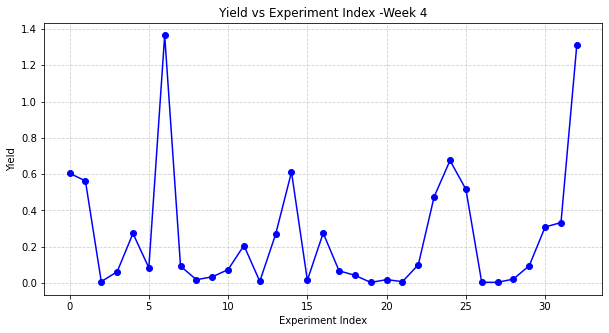

Best parameters: [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Best yield: 1.3649683044991994


In [3]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week4))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week4, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 4')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week4)
best_x = inputdata_week4[best_idx]
best_y = outputdata_week4[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: Update GP with new data

In [4]:
# Fit Gaussian Process surrogate
X_wk4 = inputdata_week4
y_wk4 = outputdata_week4


kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                              n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk4, y_wk4)

# Generate candidate hyperparameters
X_candidates = np.random.rand(5000, 6)  # 6D hyperparameter space

# Predict mean and std with GP
mu, sigma = gp.predict(X_candidates, return_std=True)


## step 4: Update acquisition function

In [6]:
# Compute Expected Improvement (EI)
from scipy.stats import norm

y_max = y_wk4.max()
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Select next hyperparameters to try
x_next = X_candidates[np.argmax(EI)]
print("Next hyperparameters to test:", np.round(x_next,6))

Next hyperparameters to test: [0.112753 0.296341 0.273379 0.154734 0.250447 0.754892]


# ******* Week 5 update ********

# Step 1: Load in data

In [2]:
inputdata = np.load('inputs_week4.npy')
outputdata = np.load('outputs_week4.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week4/inputs.txt', 'r') as f:
    inputs_week5 = f.read()

with open('../Inputs_Outputs/Week4/outputs.txt', 'r') as f:
    outputs_week5 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week5 = eval(inputs_week5, {"__builtins__": {}}, safe_globals)
outputs_week5 = eval(outputs_week5, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week5 = np.array(inputs_week5, dtype=object)
outputs_week5 = np.array(outputs_week5, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F7_inputs_week5 = inputs_week5[6]
F7_outputs_week5 = outputs_week5[6]



# Step 5: merge with previous data
F7_inputs_week5 = F7_inputs_week5.reshape(1, -1)
inputdata_week5 = np.concatenate((inputdata,F7_inputs_week5), axis=0)

outputdata_week5 = np.concatenate((outputdata,np.array([F7_outputs_week5])))

print(inputdata_week5)
print(outputdata_week5)

#Save results
np.save('inputs_week5.npy', inputdata_week5)
np.save('outputs_week5.npy', outputdata_week5)

[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72880565

# Step 2: Visualise the results

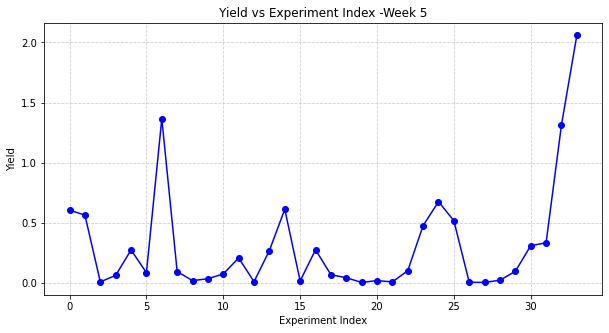

Best parameters: [0.112753 0.296341 0.273379 0.154734 0.250447 0.754892]
Best yield: 2.059100507687065


In [3]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week5))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week5, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index -Week 5')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week5)
best_x = inputdata_week5[best_idx]
best_y = outputdata_week5[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: Update GP surrogate model

In [4]:
# Fit Gaussian Process surrogate
X_wk5 = inputdata_week5
y_wk5 = outputdata_week5


kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                              n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk5, y_wk5)

# Generate candidate hyperparameters
X_candidates = np.random.rand(5000, 6)  # 6D hyperparameter space

# Predict mean and std with GP
mu, sigma = gp.predict(X_candidates, return_std=True)



## Step 4: Fit acquisition function

In [5]:
# Compute Expected Improvement (EI)
from scipy.stats import norm

y_max = y_wk5.max()
sigma_nonzero = np.copy(sigma)
sigma_nonzero[sigma_nonzero == 0] = 1e-12
z = (mu - y_max) / sigma_nonzero
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Select next hyperparameters to try
x_next = X_candidates[np.argmax(EI)]
print("Next hyperparameters to test:", np.round(x_next,6))

Next hyperparameters to test: [0.105354 0.385274 0.247982 0.217507 0.216116 0.628878]


# **** Week 6 *****

## Step 1: Upload updated data

In [2]:
inputdata = np.load('inputs_week5.npy')
outputdata = np.load('outputs_week5.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week5/inputs.txt', 'r') as f:
    inputs_week6 = f.read()

with open('../Inputs_Outputs/Week5/outputs.txt', 'r') as f:
    outputs_week6 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week6 = eval(inputs_week6, {"__builtins__": {}}, safe_globals)
outputs_week6 = eval(outputs_week6, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week6 = np.array(inputs_week6, dtype=object)
outputs_week6 = np.array(outputs_week6, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F7_inputs_week6 = inputs_week6[6]
F7_outputs_week6 = outputs_week6[6]



# Step 5: merge with previous data
F7_inputs_week6 = F7_inputs_week6.reshape(1, -1)
inputdata_week6 = np.concatenate((inputdata,F7_inputs_week6), axis=0)

outputdata_week6 = np.concatenate((outputdata,np.array([F7_outputs_week6])))

print(inputdata_week6)
print(outputdata_week6)

#Save results
np.save('inputs_week6.npy', inputdata_week6)
np.save('outputs_week6.npy', outputdata_week6)

[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72880565

## Step 2: Plot outputs

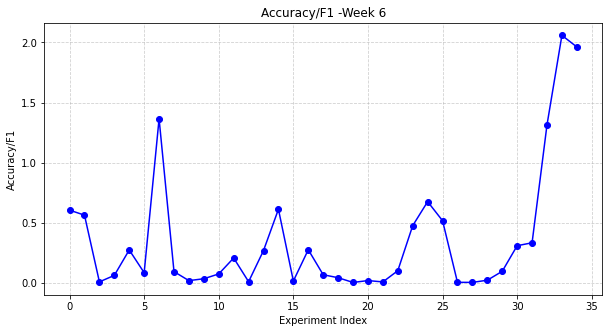

Best parameters: [0.112753 0.296341 0.273379 0.154734 0.250447 0.754892]
Best yield: 2.059100507687065


In [5]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week6))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week6, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy/F1')
plt.title('Accuracy/F1 -Week 6')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week6)
best_x = inputdata_week6[best_idx]
best_y = outputdata_week6[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

### Things to improve this week

#### 1. Acquisition function - generally EI struggles at this level of dimensionality. EI is best when dimensionality is below 4, the function is smooth and noise is low. 
#### 2. Kernel is over-smooth and isotropic - some parameters may be more sensitive than others, herefore the kernel should represent this and be more anisotropic. 
#### 3. Random candidate sampling is weak in six dimensional data, good regions can be easy o miss with 5000 points being quite sparse.


### How to resolve this

#### 1. Transform the target - scoresvary by orders of magnitude which GPs do not work well with. Worth using a log transform 
#### 2. Use a rougher kernel (e.g., anisotropic)
#### 3. Replace EI with a robust UCB acquisition function (much more stable at this dimensionality. 
#### 4. Bias my search near to known good configurations like how TuRBO works. 

## Step 3: Log transform output and use rougher kernel for GP surrogate model

In [7]:
from scipy.stats import rankdata

X_wk6=inputdata_week6
y_wk6=outputdata_week6

y_transformed = rankdata(y_wk6)

# Update kernel and fit GP
kernel = Matern(
    length_scale=np.ones(6) * 0.3,
    length_scale_bounds=(1e-2, 2.0),
    nu=1.5
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)
gp.fit(X_wk6, y_transformed)


/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=1e-06,
                         kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3], nu=1.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=42)

## Step 4: Fit UCB acquisition function 

In [8]:
X_candidates = np.random.rand(10000, 6)

mu, sigma = gp.predict(X_candidates, return_std=True)
sigma = np.maximum(sigma, 1e-9)

# UCB acquisition
kappa = 1.0          # exploration
risk_penalty = 0.3   # robustness

acq = mu + kappa * sigma - risk_penalty * sigma


## Step 5: Apply trust-region bias to then find next candidates

In [9]:
best_idx = np.argmax(y_transformed)
x_best = X_wk6[best_idx]

dist = np.linalg.norm(X_candidates - x_best, axis=1)
acq *= np.exp(-dist / 0.5)

# -----------------------------
# 7. Select next hyperparameters
# -----------------------------
x_next = X_candidates[np.argmax(acq)]
print("Next hyperparameters to test:", np.round(x_next, 6))

Next hyperparameters to test: [0.075991 0.188195 0.372363 0.228221 0.196483 0.749247]


# ******* Week 7 ******

## Step 1: Upload updated data

In [2]:
inputdata = np.load('inputs_week6.npy')
outputdata = np.load('outputs_week6.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week6/inputs.txt', 'r') as f:
    inputs_week7 = f.read()

with open('../Inputs_Outputs/Week6/outputs.txt', 'r') as f:
    outputs_week7 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week7 = eval(inputs_week7, {"__builtins__": {}}, safe_globals)
outputs_week7 = eval(outputs_week7, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week7 = np.array(inputs_week7, dtype=object)
outputs_week7 = np.array(outputs_week7, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F7_inputs_week7 = inputs_week7[6]
F7_outputs_week7 = outputs_week7[6]



# Step 5: merge with previous data
F7_inputs_week7 = F7_inputs_week7.reshape(1, -1)
inputdata_week7 = np.concatenate((inputdata,F7_inputs_week7), axis=0)

outputdata_week7 = np.concatenate((outputdata,np.array([F7_outputs_week7])))

print(inputdata_week7)
print(outputdata_week7)

#Save results
np.save('inputs_week7.npy', inputdata_week7)
np.save('outputs_week7.npy', outputdata_week7)

[[0.27262382 0.32449536 0.89710881 0.83295115 0.15406269 0.79586362]
 [0.54300258 0.9246939  0.34156746 0.64648585 0.71844033 0.34313266]
 [0.09083225 0.66152938 0.06593091 0.25857701 0.96345285 0.6402654 ]
 [0.11886697 0.61505494 0.90581639 0.8553003  0.41363143 0.58523563]
 [0.63021764 0.8380969  0.68001305 0.73189509 0.52673671 0.34842921]
 [0.76491917 0.25588292 0.60908422 0.21807904 0.32294277 0.09579366]
 [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
 [0.19525188 0.07922665 0.55458046 0.17056682 0.01494418 0.10703171]
 [0.64230298 0.83687455 0.02179269 0.10148801 0.68307083 0.6924164 ]
 [0.78994255 0.19554501 0.57562333 0.07365919 0.25904917 0.05109986]
 [0.52849733 0.45742436 0.36009569 0.36204551 0.81689098 0.63747637]
 [0.72261522 0.01181284 0.06364591 0.16517311 0.07924415 0.35995166]
 [0.07566492 0.33450212 0.13273274 0.60831236 0.91838592 0.82233079]
 [0.94245084 0.37743962 0.48612233 0.22879108 0.08263175 0.71195755]
 [0.14864702 0.03394336 0.72880565

## Step 2: Visualise the results

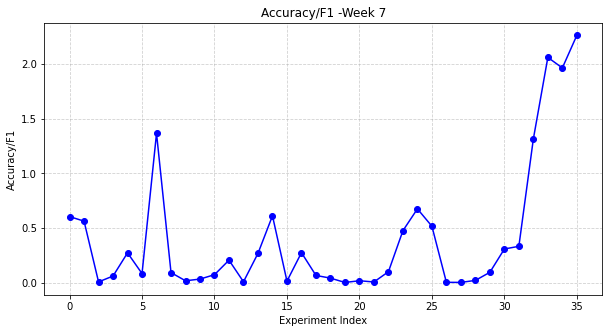

Best parameters: [0.075991 0.188195 0.372363 0.228221 0.196483 0.749247]
Best yield: 2.2605177508004988


In [3]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week7))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week7, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy/F1')
plt.title('Accuracy/F1 -Week 7')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week7)
best_x = inputdata_week7[best_idx]
best_y = outputdata_week7[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: Update GP model

In [4]:
from scipy.stats import rankdata

X_wk7=inputdata_week7
y_wk7=outputdata_week7

y_transformed = rankdata(y_wk7)

# Update kernel and fit GP
kernel = Matern(
    length_scale=np.ones(6) * 0.3,
    length_scale_bounds=(1e-2, 2.0),
    nu=1.5
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-6,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)
gp.fit(X_wk7, y_transformed)



/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=1e-06,
                         kernel=Matern(length_scale=[0.3, 0.3, 0.3, 0.3, 0.3, 0.3], nu=1.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=42)

## Step 4: Update acquisition function

In [5]:
X_candidates = np.random.rand(10000, 6)

mu, sigma = gp.predict(X_candidates, return_std=True)
sigma = np.maximum(sigma, 1e-9)

# UCB acquisition
kappa = 1.0          # exploration
risk_penalty = 0.3   # robustness

acq = mu + kappa * sigma - risk_penalty * sigma


## Step 5: Apply trust-region bias for next candidates

In [6]:
best_idx = np.argmax(y_transformed)
x_best = X_wk7[best_idx]

dist = np.linalg.norm(X_candidates - x_best, axis=1)
acq *= np.exp(-dist / 0.5)

# -----------------------------
# 7. Select next hyperparameters
# -----------------------------
x_next = X_candidates[np.argmax(acq)]
print("Next hyperparameters to test:", np.round(x_next, 6))

Next hyperparameters to test: [0.195079 0.163072 0.457566 0.223396 0.180766 0.722072]
